# **Import Library:**

In [82]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l2
import pathlib

# **Mempersiapkan dataset:**

In [2]:
! pip install kaggle

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/Kaggle"
!mkdir /content/Kaggle
%cd /content/Kaggle

/content/Kaggle


In [4]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d sujaykapadnis/emotion-recognition-dataset

 99% 1.97G/1.98G [00:19<00:00, 96.4MB/s]
100% 1.98G/1.98G [00:19<00:00, 106MB/s] 


In [6]:
!unzip \emotion-recognition-dataset.zip && rm emotion-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Sad/0a12a7e998fa7abde73e79ce2a74477bdc6f5dd010da05231f4c3330.jpg  
  inflating: dataset/Sad/0a1370fc7e34586d5f134694c9d1e79ed4cce9e59684077ae5061db8.png  
  inflating: dataset/Sad/0a14abb2a25753914205e88e870054918de36219552002f3144b8455.jpg  
  inflating: dataset/Sad/0a15eede4e05e13f70f6540c4167282f9a488cc318005c8693c49433.jpg  
  inflating: dataset/Sad/0a163aa46984ad37b58aa6b8175dca9b1007a3066099d18f4dda6f78.jpg  
  inflating: dataset/Sad/0a1833eb2427bd8c1ddd3b9c020c6233a3671763e21b1e08b5afa41f.jpg  
  inflating: dataset/Sad/0a19842e87935fbd2c45a7042e4bb8d1d3816476e8a6b7e8f41205d8.jpg  
  inflating: dataset/Sad/0a1d613237e9af295213c61e1c2b9d7fd211fad638c522afb9548901.jpg  
  inflating: dataset/Sad/0a1d86074a08f9bf55858cf90eaaee6f1e0362d97f08cbaa161e30e0.jpg  
  inflating: dataset/Sad/0a22b8d3b2fbcbebb6a4be7dad0a37b92983e8afe42b4d48cded4e45.jpg  
  inflating: dataset/Sad/0a285a2a07f0f8daaa0a821e30ad2e558ddc18f2589a

In [7]:
dataset_path = '/content/Kaggle/dataset'

os.listdir(dataset_path)

['Sad', 'Happy', 'Angry', 'Surprise', 'Ahegao', 'Neutral']

# **Menghitung jumlah dataset & Menampilkan Sample Gambar:**

Jumlah total gambar dalam dataset: 15453


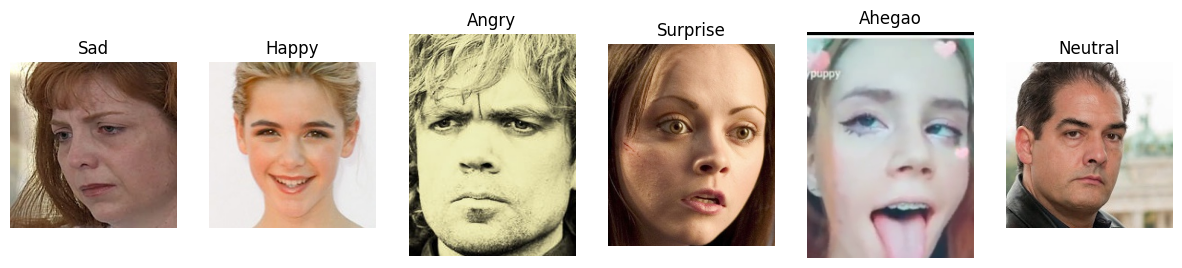

In [8]:
categories = os.listdir(dataset_path)
categories_path = []
images_sample = []

# Hitung jumlah total gambar dalam setiap kategori
total_images = 0
for category in categories:
    category_path = os.path.join(dataset_path, category)
    categories_path.append(category_path)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        images_sample.append(images[random.randint(1, 100)])
        total_images += len(images)

print(f"Jumlah total gambar dalam dataset: {total_images}")

# Membuat subplot dengan ukuran kolom x baris
fig, axes = plt.subplots(1, 6, figsize=(15, 3))

for i in range(6):
  img = plt.imread(categories_path[i] + "/" + images_sample[i])
  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(f'{categories[i]}')

plt.show()

# **Membuat Augmentasi:**

In [31]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    # brightness_range=[0.8, 1.2],  # Variasi tingkat kecerahan
                    # channel_shift_range=50,  # Perubahan acak dalam tingkat warna
                    # zoom_range=0.2,
                    fill_mode = 'nearest',
                    # width_shift_range=0.1,  # Geser gambar secara horizontal hingga 10% lebar gambar
                    # height_shift_range=0.1,  # Geser gambar secara vertikal hingga 10% tinggi gambar
                    validation_split=0.2,) # validation 20%

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split=0.2,)

# **Membagi Dataset & image preprocessing:**

In [49]:
train_generator = train_datagen.flow_from_directory(
        dataset_path,  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=64,
        class_mode='categorical',
        shuffle=True,  # Menambahkan parameter shuffle
        seed=42,  # Menambahkan parameter seed
        subset='training')

validation_generator = test_datagen.flow_from_directory(
        dataset_path, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=64,
        class_mode='categorical',
        shuffle=True,  # Menambahkan parameter shuffle
        seed=42,  # Menambahkan parameter seed
        subset='validation')

Found 12365 images belonging to 6 classes.
Found 3088 images belonging to 6 classes.


# **Menghitung & Melihat Grafik Distribusi Data Kelas:**

**Menampilkan distribusi data tiap kelas:**

In [50]:
# Mendapatkan daftar kelas dan indeks kelas dari generator aliran data
class_indices = train_generator.class_indices

# Membalikkan mapping untuk mendapatkan nama kelas dari indeks kelas
class_names = list(class_indices.keys())

# Mendapatkan jumlah sampel untuk setiap kelas
class_distribution = train_generator.classes

# Menghitung jumlah sampel untuk setiap kelas
class_count = {class_name: sum(class_distribution == class_index) for class_name, class_index in class_indices.items()}

# Menampilkan distribusi tiap kelas
print("Class Distribution:")
for class_name, count in class_count.items():
    print(f"{class_name}: {count} samples")

Class Distribution:
Ahegao: 964 samples
Angry: 1051 samples
Happy: 2992 samples
Neutral: 3222 samples
Sad: 3148 samples
Surprise: 988 samples


**Menampilkan Index Kelas:**

In [51]:
print("Class Index:")
for class_name, class_index in class_indices.items():
  print(f"{class_name} : {class_index}")

Class Index:
Ahegao : 0
Angry : 1
Happy : 2
Neutral : 3
Sad : 4
Surprise : 5


**Menampilkan Grafik Distribusi:**

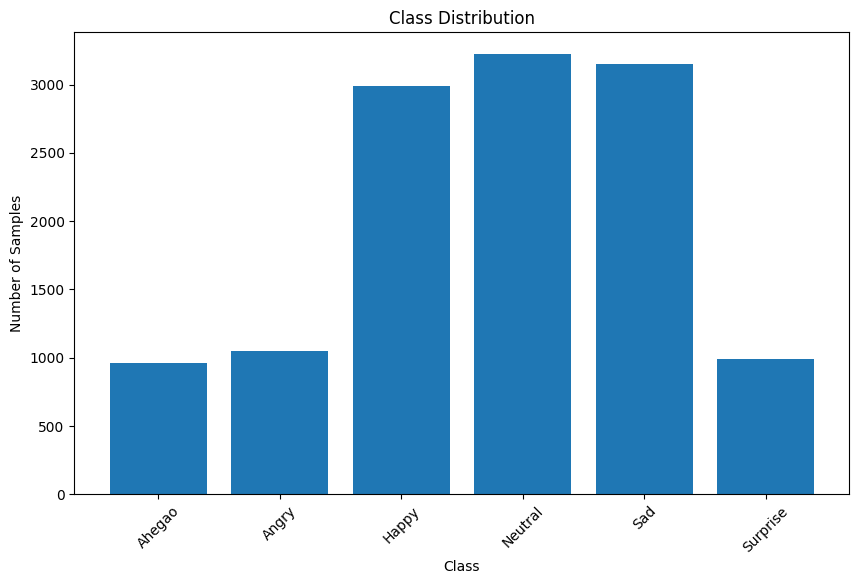

In [52]:
import matplotlib.pyplot as plt

# Daftar kelas dan jumlah sampel untuk setiap kelas
class_names = list(class_count.keys())
class_counts = list(class_count.values())

# Membuat plot
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()


# **Menentukan Weight Untuk Setiap Kelas Karena Dataset Tidak Seimbang:**

In [53]:
# # Menghitung jumlah sampel untuk setiap kelas
class_count = {class_index: sum(class_distribution == class_index) for class_index in range(len(class_indices))}


# Bobot kelas
class_weights = {class_index: len(class_distribution) / count for class_index, count in class_count.items()}
print("Class Weights:", class_weights)

Class Weights: {0: 12.826763485477178, 1: 11.76498572787821, 2: 4.132687165775401, 3: 3.8376784605834886, 4: 3.9278907242693775, 5: 12.515182186234817}


# **Membuat Model:**

In [70]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='ELU', input_shape=(150, 150, 3),),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='ELU',),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='ELU',),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='ELU',),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='ELU',),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='ELU'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])


In [71]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        256       
 chNormalization)                                                
                                                      

In [72]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# **Pelatihan Model:**

In [73]:
threshold = 80 * 1 / 100
print(f"target accuracy : {threshold}")

target accuracy : 0.8


In [74]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > threshold and logs.get('val_accuracy') > threshold):
      print('\nAccuracy diatas 80% tercapai')
      self.model.stop_training = True
callbacks = myCallback()

# Callback untuk mengurangi learning rate jika loss tidak berkurang
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# # Callback untuk early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

steps_per_epoch =  class_distribution
validation_step = validation_generator.classes

# latih model dengan model.fit
history = model.fit(
      train_generator,
      steps_per_epoch=60,
      epochs=100, # tambahkan epochs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=23,
      class_weight=class_weights,
      callbacks=[
          # early_stopping,
          reduce_lr,
          myCallback()
          ],
      verbose=2)

Epoch 1/100
60/60 - 53s - loss: 18.6773 - accuracy: 0.2615 - val_loss: 2.5011 - val_accuracy: 0.2901 - lr: 0.0010 - 53s/epoch - 877ms/step
Epoch 2/100
60/60 - 50s - loss: 12.0819 - accuracy: 0.3310 - val_loss: 2.1111 - val_accuracy: 0.2704 - lr: 0.0010 - 50s/epoch - 833ms/step
Epoch 3/100
60/60 - 50s - loss: 9.8173 - accuracy: 0.3869 - val_loss: 2.6035 - val_accuracy: 0.2758 - lr: 0.0010 - 50s/epoch - 834ms/step
Epoch 4/100
60/60 - 49s - loss: 9.2081 - accuracy: 0.4177 - val_loss: 1.7187 - val_accuracy: 0.3546 - lr: 0.0010 - 49s/epoch - 816ms/step
Epoch 5/100
60/60 - 49s - loss: 8.6994 - accuracy: 0.4495 - val_loss: 1.4293 - val_accuracy: 0.4518 - lr: 0.0010 - 49s/epoch - 821ms/step
Epoch 6/100
60/60 - 50s - loss: 7.8308 - accuracy: 0.4706 - val_loss: 1.3878 - val_accuracy: 0.4898 - lr: 0.0010 - 50s/epoch - 826ms/step
Epoch 7/100
60/60 - 50s - loss: 7.8176 - accuracy: 0.4872 - val_loss: 1.2898 - val_accuracy: 0.4925 - lr: 0.0010 - 50s/epoch - 827ms/step
Epoch 8/100
60/60 - 49s - loss: 

# **Menampilkan Grafik**

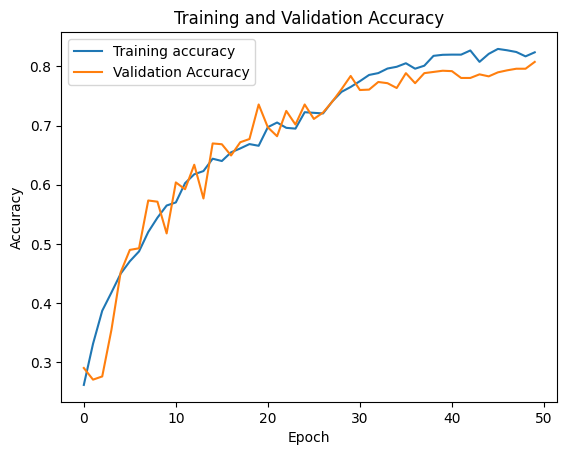

In [78]:
# melihat grafik training loss dan validation loss

# Gambar grafik loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

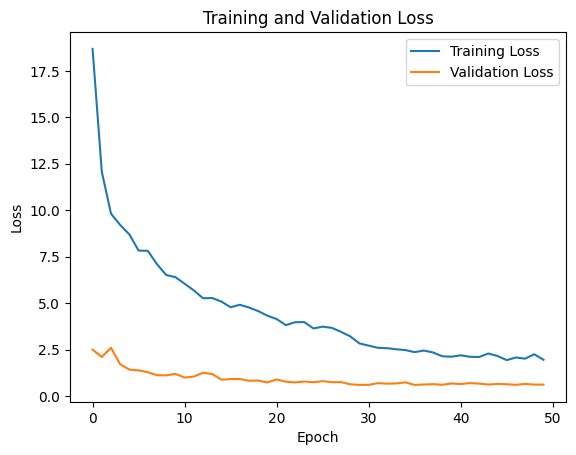

In [80]:
# Grafik Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Membuat & Menyimpan Model**

In [83]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi faceEmotion.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('faceEmotion.tflite')
tflite_model_file.write_bytes(tflite_model)

10500392